# Projet : Autour du Google Hash Code 2019 "Photo slideshow"

Binôme : Valentin COLLIARD et Madina TRAORE

#### Modules et classes utilisés

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from gurobipy import *

In [2]:
class Photo:
    """
        Classe représentant une photo
    """
    def __init__(self, index, orientation, tags):
        self.index = index # indice de la photo au sein de l'instance
        self.orientation = orientation # orientation de la photo : horizontale ("H") ou verticale ("V")
        self.tags = tags # mots-clés associés à la photo
    
    # Les méthodes suivantes permettent simplement d'afficher tous les attributs d'une instance de la classe Photo
    
    def __str__(self):
        return str(self.index)+" "+str(self.orientation)+" "+str(self.tags) 

    def __repr__(self):
        return self.__str__()

In [3]:
class Instance:
    """
        Classe représentant une instance de n photos
    """
    def __init__(self, n, photosH, photosV):
        self.n = n # nombre de photos
        self.photosH = photosH # liste des photos horizontales de la présentation
        self.photosV = photosV # liste des photos verticales de la présentation
    
    # Les méthodes suivantes permettent simplement d'afficher tous les attributs d'une instance de la classe Photo
    
    def __str__(self):
        return "Nombre de photos : " + str(self.n)+"\nPhotos horizontales : "+str(self.photosH)+"\nPhotos verticales : "+str(self.photosV) 

    def __repr__(self):
        return self.__str__()

In [4]:
class Vignette:
    """
        Classe représentant une vignette (constituée d'une photo horizontale ou de 2 photos verticales)
    """
    def __init__(self, photo1, photo2 = None):
        self.photo1 = photo1
        self.photo2 = photo2
        if self.photo2 == None:
            self.tags = self.photo1.tags
        else:
            self.tags = [tag for tag in photo1.tags]
            self.tags += [tag for tag in photo2.tags if tag not in self.tags]
    
    # Les méthodes suivantes permettent simplement d'afficher tous les attributs d'une instance de la classe Photo
    
    def __str__(self):
        if self.photo2 == None:
            s = ""
        else:
            s = str(self.photo2)
        return str(self.photo1)+" "+s
    
    def __repr__(self):
        return self.__str__()

In [160]:
class Presentation:
    """
        Classe représentant une présentation
    """
    def __init__(self, vignettes):
        self.vignettes = vignettes # liste de vignettes de la présentation
        self.n = len(self.vignettes)
        
    # Les méthodes suivantes permettent simplement d'afficher tous les attributs d'une instance de la classe Photo
    
    def __str__(self):
        l = [self.vignettes[i].__str__() for i in range(len(self.vignettes))]
        return "\n".join(l)

    def __repr__(self):
        return self.__str__()

In [391]:
class Transition:

    def __init__(self, vignette1, vignette2, score):
        self.score = score
        self.vignette1 = vignette1
        self.vignette2 = vignette2

    def __str__(self):
        return str(self.vignette1)+" "+str(self.vignette2)+" "+str(self.score)
    
    def __repr__(self):
        return self.__str__()

## Entrées-Sorties

In [6]:
def lire(nom_fichier, p):
    """
        Fonction permettant de lire p% d'une instance de n photos donnée
    """
    fichier = open(nom_fichier,'r')
    n = int(fichier.readline().strip("\n"))
    nbPhotos = int(np.floor(p*n/100)) # nombre de photos dans l'instance réduite
    photosH = [] # photos horizontales
    photosV = [] # photos verticales
    for i in range(nbPhotos):
        ligne = fichier.readline().strip("\n")
        ligne = ligne.split(" ")
        if ligne[0] == "H":
            photosH.append(Photo(i,ligne[0],ligne[2:]))
        elif ligne[0] == "V":
            photosV.append(Photo(i,ligne[0],ligne[2:]))
    fichier.close()
    instance = Instance(nbPhotos,photosH,photosV)
    return instance

In [7]:
def presentationHV(instance):
    """
        Fonction permettant d'obtenir une présentation simple (photos horizontales puis photos verticales) d'une instance donnée
        Remarque : S'il y a un nombre impair de photos verticales,l'une d'entre elles ne peut être mise dans la présentation
    """
    vignettes = []
    for photo in instance.photosH:
        vignettes.append(Vignette(photo)) # on ajoute toutes les photos horizontales a la presentation
    if len(instance.photosV)%2:
        nbPhotosV = len(instance.photosV)
    else:
        nbPhotosV = len(instance.photosV) - 1
    for i in range(0,nbPhotosV,2):
        vignettes.append(Vignette(instance.photosV[i],instance.photosV[i+1]))
    return Presentation(vignettes)

In [8]:
def ecrire(presentation, nom_fichier):
    """
        Fonction permettant d'écrire une présentation (une solution) dans un fichier
    """
    instance = open(nom_fichier+".sol",'w')
    vignettes = presentation.vignettes
    nb_vignettes = str(len(vignettes))
    instance.write(nb_vignettes+"\n")
    for vignette in vignettes:
        if vignette.photo2 == None:
            instance.write(str(vignette.photo1.index)+"\n")
        else :
            instance.write(str(vignette.photo1.index)+" "+str(vignette.photo2.index)+"\n")
    instance.close()

In [9]:
def score_t(S1, S2):
    """
        Fonction permettant de calculer le score de la transition S1 --> S2
    """
    nb_tags_S1_S2 = 0 # nombre de mots-clé communs entre S1 et S2
    nb_tags_S1 = 0 # nombre de mots-clé apparaissant dans S1 mais pas dans S2
    nb_tags_S2 = 0 # nombre de mots-clé apparaissant dans S2 mais pas dans S1
    for tag in S1.tags:
        if tag in S2.tags:
            nb_tags_S1_S2 += 1
        else:
            nb_tags_S1 += 1
    for tag in S2.tags:
        if tag not in S1.tags:
            nb_tags_S2 += 1
    return min(nb_tags_S1_S2,nb_tags_S1,nb_tags_S2)

def score_p(presentation):
    """
        Fonction permettant de calculer le score de la presentation (solution) donnee
    """
    s = 0
    vignettes = presentation.vignettes
    for i in range(len(vignettes) - 1):
        S1 = vignettes[i] # vignette S_i
        S2 = vignettes[i+1] # vignette S_i+1
        s += score_t(S1,S2) 
    return s

In [10]:
instance = lire("qualification_round_2019.in/a_example.txt",100)
print(instance)

Nombre de photos : 4
Photos horizontales : [0 H ['cat', 'beach', 'sun'], 3 H ['garden', 'cat']]
Photos verticales : [1 V ['selfie', 'smile'], 2 V ['garden', 'selfie']]


In [11]:
presentation = presentationHV(instance)
print(presentation)

0 H ['cat', 'beach', 'sun'] 
3 H ['garden', 'cat'] 
1 V ['selfie', 'smile'] 2 V ['garden', 'selfie']


In [12]:
ecrire(presentation,"qualification_round_2019.in/a_example")
score_p(presentation)

2

In [13]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",100)
presentation = presentationHV(instance)
ecrire(presentation,"qualification_round_2019.in/b_lovely_landscapes")
score_p(presentation)

12

In [14]:
instance = lire("qualification_round_2019.in/c_memorable_moments.txt",100)
presentation = presentationHV(instance)
ecrire(presentation,"qualification_round_2019.in/c_memorable_moments")
score_p(presentation)

152

In [15]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",100)
presentation = presentationHV(instance)
ecrire(presentation,"qualification_round_2019.in/d_pet_pictures")
score_p(presentation)

190961

In [16]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",100)
presentation = presentationHV(instance)
ecrire(presentation,"qualification_round_2019.in/e_shiny_selfies")
score_p(presentation)

112468

## Méthodes gloutonnes

In [17]:
def methodeGloutonne1(instance):
    """
        Implémentation de la méthode gloutonne suivante :
        - Commencer par une vignette contenant une photo H ou un couple de photos V choisies au hasard
        - Ajouter itérativement après la vignette S_i une vignette S_i+1 constituée d'une photo H ou V (non sélectionnée jusqu'ici)
          maximisant la transition. S'il s'agit d'une photo V, compléter ensuite la vignette en choisissant une photo V
          maximisant la transition
    """
    vignettes = []
    photos = list(instance.photosH + instance.photosV)
    photo1 = photos[np.random.randint(0,len(photos))]
    if (photo1.orientation == "H"):
        vignettes.append(Vignette(photo1,None))
        photos.remove(photo1)
    else:
        photos.remove(photo1)
        photo2 = photos[np.random.randint(0,len(photos))]
        vignettes.append(Vignette(photo1,photo2))
        photos.remove(photo2)
        
    V_cour = vignettes[0] # vignette courante (S_i)
    while len(photos)>0:
        best_photo1_suiv = None
        max_score = 0
        for photo in photos:
            score = score_t(V_cour,photo)
            if score >= max_score:
                max_score = score
                best_photo1_suiv = photo
        if best_photo1_suiv.orientation == "H":
            V_cour = Vignette(best_photo1_suiv,None)
            vignettes.append(V_cour)
            photos.remove(best_photo1_suiv)
        else:
            best_photo2_suiv = None
            max_score = 0
            for photo in [p for p in photos if p.orientation == "V" and p != best_photo1_suiv]:
                score = score_t(V_cour,Vignette(best_photo1_suiv,photo))
                if score >= max_score:
                    max_score = score
                    best_photo2_suiv = photo
            if best_photo2_suiv != None:
                V_cour = Vignette(best_photo1_suiv,best_photo2_suiv)
                vignettes.append(V_cour)
                photos.remove(best_photo1_suiv)
                photos.remove(best_photo2_suiv)
            else:
                photos.remove(best_photo1_suiv)
    return Presentation(vignettes)

In [410]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",1)
presentation = methodeGloutonne1(instance)
ecrire(presentation,"sol/MethodeGloutonne1/b_lovely_landscapes")
score_p(presentation)

57

In [411]:
instance = lire("qualification_round_2019.in/c_memorable_moments.txt",100)
presentation = methodeGloutonne1(instance)
ecrire(presentation,"sol/MethodeGloutonne1/c_memorable_moments")
score_p(presentation)

1767

In [412]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",1)
presentation = methodeGloutonne1(instance)
ecrire(presentation,"sol/MethodeGloutonne1/d_pet_pictures")
score_p(presentation)

3701

In [413]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",1)
presentation = methodeGloutonne1(instance)
ecrire(presentation,"sol/MethodeGloutonne1/e_shiny_selfies")
score_p(presentation)

3884

On fait croître la taille d'une instance pour évaluer la méthode :

In [326]:
tailles = [0]
temps = [0]
for i in range(1,10):
    instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",i)
    tdebut = time.clock()
    presentation = methodeGloutonne1(instance)
    tfin = time.clock()
    tailles.append(instance.n) # taille des instances
    t = tfin - tdebut
    temps.append(t)
    print("Taille :",instance.n)
    print("Temps :",t,"s")

Taille : 800
Temps : 4.1121860000002926 s
Taille : 1600
Temps : 16.76168300000063 s
Taille : 2400
Temps : 36.58805200000006 s
Taille : 3200
Temps : 64.06715799999984 s
Taille : 4000
Temps : 101.14819099999931 s
Taille : 4800
Temps : 145.81092499999977 s
Taille : 5600
Temps : 193.6695840000002 s
Taille : 6400
Temps : 255.18010199999935 s
Taille : 7200
Temps : 322.4162669999996 s


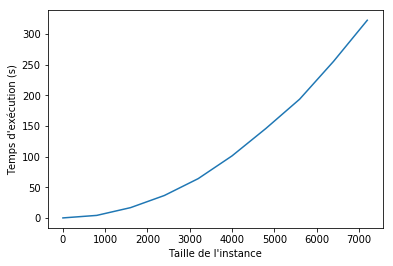

In [327]:
plt.plot(tailles,temps)
plt.xlabel("Taille de l'instance")
plt.ylabel("Temps d'exécution (s)")
plt.show()

In [347]:
def methodeGloutonne2(instance):
    """
        Implémentation de la méthode gloutonne suivante :
        - Commencer par une vignette contenant une photo H ou un couple de photos V choisies au hasard
        - Ajouter une fois sur 2 une vignette maximisant le score de la transition, le reste du temps
          ajouter une vignette choisie de maniere aleatoire
    """
    vignettes = []
    photosH = list(instance.photosH) # copie
    photosV = list(instance.photosV)
    photos = photosH + photosV
    photo1 = photos[np.random.randint(0,len(photos))]
    if photo1.orientation == "H":
        vignettes.append(Vignette(photo1))
        photosH.remove(photo1)
        photos = photosH + photosV
    else:
        if len(photosV) > 1:
            photosV.remove(photo1)
            photo2 = photosV[np.random.randint(0,len(photosV))]
            vignettes.append(Vignette(photo1,photo2))
            photosV.remove(photo2)
            photos = photosH + photosV
        else:
            photosV.remove(photo1)
        
    V_cour = vignettes[0] # vignette courante (S_i)
    while len(photos)>0:
        if np.random.random() > 0.5:
            best_photo1_suiv = None
            max_score = 0
            for photo in photos:
                score = score_t(V_cour,photo)
                if score >= max_score:
                    max_score = score
                    best_photo1_suiv = photo
            if best_photo1_suiv.orientation == "H":
                V_cour = Vignette(best_photo1_suiv,None)
                vignettes.append(V_cour)
                photosH.remove(best_photo1_suiv)
            else:
                best_photo2_suiv = None
                max_score = 0
                for photo in [p for p in photos if p.orientation == "V" and p != best_photo1_suiv]:
                    score = score_t(V_cour,Vignette(best_photo1_suiv,photo))
                    if score >= max_score:
                        max_score = score
                        best_photo2_suiv = photo
                if best_photo2_suiv != None:
                    V_cour = Vignette(best_photo1_suiv,best_photo2_suiv)
                    vignettes.append(V_cour)
                    photosV.remove(best_photo1_suiv)
                    photosV.remove(best_photo2_suiv)
                else:
                    photos.remove(best_photo1_suiv)
            photos = photosH + photosV
        else:
            photo1 = photos[np.random.randint(0,len(photos))]
            if photo1.orientation == "H":
                V_cour = Vignette(photo1,None)
                vignettes.append(V_cour)
                photosH.remove(photo1)
            else:
                if len(photosV) > 1:
                    photosV.remove(photo1)
                    photo2 = photosV[np.random.randint(0,len(photosV))]
                    V_cour = Vignette(photo1,photo2)
                    vignettes.append(V_cour)
                    photosV.remove(photo2)
                else:
                    photosV.remove(photo1)
            photos = photosH + photosV
            
    return Presentation(vignettes)

In [348]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",1)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/b_lovely_landscapes")
score_p(presentation)

36

In [349]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",2)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/b_lovely_landscapes")
score_p(presentation)

114

In [350]:
instance = lire("qualification_round_2019.in/c_memorable_moments.txt",100)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/c_memorable_moments")
score_p(presentation)

938

In [351]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",1)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/d_pet_pictures")
score_p(presentation)

2597

In [352]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",2)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/d_pet_pictures")
score_p(presentation)

5329

In [353]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",1)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/e_shiny_selfies")
score_p(presentation)

2654

In [354]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",2)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/e_shiny_selfies")
score_p(presentation)

5291

In [324]:
tailles = [0]
temps = [0]
for i in range(1,10):
    instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",i)
    tdebut = time.clock()
    presentation = methodeGloutonne2(instance)
    tfin = time.clock()
    tailles.append(instance.n)
    t = tfin - tdebut
    temps.append(t)
    print("Taille :",instance.n)
    print("Temps :",t,"s")

Taille : 800
Temps : 1.9974870000005467 s
Taille : 1600
Temps : 7.564672000000428 s
Taille : 2400
Temps : 19.35297999999966 s
Taille : 3200
Temps : 32.575261999999384 s
Taille : 4000
Temps : 48.627477 s
Taille : 4800
Temps : 67.82017999999971 s
Taille : 5600
Temps : 94.36117099999956 s
Taille : 6400
Temps : 125.591633 s
Taille : 7200
Temps : 151.9394139999995 s


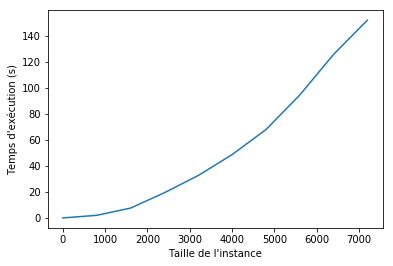

In [325]:
plt.plot(tailles,temps)
plt.xlabel("Taille de l'instance")
plt.ylabel("Temps d'exécution (s)")
plt.show()

In [295]:
def presentationAleatoire(instance):
    vignettes = []
    photosH = list(instance.photosH)
    photosV = list(instance.photosV)
    photos = photosH + photosV
    while len(photos)>0:
        photo1 = photos[np.random.randint(0,len(photos))]
        if photo1.orientation == "H":
            vignettes.append(Vignette(photo1))
            photosH.remove(photo1)
            photos = photosH + photosV
        else:
            if len(photosV) > 1:
                photosV.remove(photo1)
                photo2 = photosV[np.random.randint(0,len(photosV))]
                vignettes.append(Vignette(photo1,photo2))
                photosV.remove(photo2)
                photos = photosH + photosV
            else:
                photosV.remove(photo1)
    return Presentation(vignettes)

In [296]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",1)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/b_lovely_landscapes")
score_p(presentation)

0

In [297]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",100)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/b_lovely_landscapes")
score_p(presentation)

12

In [146]:
instance = lire("qualification_round_2019.in/c_memorable_moments.txt",100)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/c_memorable_moments")
score_p(presentation)

141

In [148]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",5)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/d_pet_pictures")
score_p(presentation)

8963

In [149]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",100)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/d_pet_pictures")
score_p(presentation)

175802

In [150]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",3)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/e_shiny_selfies")
score_p(presentation)

3343

In [151]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",100)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/e_shiny_selfies")
score_p(presentation)

112459

In [319]:
tailles = [0]
temps = [0]
for i in range(1,10):
    instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",i)
    tdebut = time.clock()
    presentation = presentationAleatoire(instance)
    tfin = time.clock()
    tailles.append(instance.n)
    t = tfin - tdebut
    temps.append(t)
    print("Taille :",instance.n)
    print("Temps :",t,"s")

Taille : 800
Temps : 0.015951000000313797 s
Taille : 1600
Temps : 0.029377999999269377 s
Taille : 2400
Temps : 0.0366970000004585 s
Taille : 3200
Temps : 0.07083899999997811 s
Taille : 4000
Temps : 0.14236500000060914 s
Taille : 4800
Temps : 0.16406800000004296 s
Taille : 5600
Temps : 0.23007700000016484 s
Taille : 6400
Temps : 0.29532300000028044 s
Taille : 7200
Temps : 0.38493000000016764 s


## Méta-heuristiques

In [103]:
def desc(presentation):
    meilleure_sol = None # meilleure solution rencontrée au cours de la descente
    x = presentation # solution que l'on explore
    c = False # booléen indiquant si un voisin améliorant a été trouvé ou non
    B = []
    score_B = []
    score_max = score_p(presentation)
    cpt = 0
    while cpt < 10 and x != meilleure_sol:
        meilleure_sol = x
        score_x = score_p(x)
        print("Score à l'itération",cpt,":",score_x)
        B = [x]
        score_B = [score_x]
        if np.random.random() > 0.5:
            #print("Permuter vignettes")
            # generation du voisinage
            vignettes = x.vignettes
            for i in range(1,len(vignettes)-1):
                #for j in range(i+1,len(vignettes)):
                y = vignettes[:i]
                y.append(vignettes[i+1])
                y.append(vignettes[i])
                y += vignettes[i+2:]
                y = Presentation(y)
                score_y = score_p(y)
                #print(score_y)
                if score_y > score_x:
                    x = y
                    B = [y]
                    score_B = [score_y]
                elif score_y == score_x:
                    B.append(y)
                    score_B.append(score_y)
            x = B[score_B.index(max(score_B))]
        else:
            #print("Permuter une des deux photos V entre deux vignettes")
            vignettesV = []
            for vignette in x.vignettes:
                if vignette.photo2 != None:
                    vignettesV.append(vignette)
            # generation du voisinage
            vignettes = x.vignettes
            for i in range(1,len(vignettesV) - 1):
                #for j in range(i+1,len(vignettesV)):
                if np.random.random() > 0.5:
                    new_v1 = Vignette(vignettesV[i].photo1,vignettesV[i+1].photo1)
                    new_v2 = Vignette(vignettesV[i].photo2,vignettesV[i+1].photo2)
                    y = vignettes[:vignettes.index(vignettesV[i])]
                    y.append(new_v1)
                    y += vignettes[vignettes.index(vignettesV[i])+1:vignettes.index(vignettesV[i+1])]
                    y.append(new_v2)
                    y += vignettes[vignettes.index(vignettesV[i+1])+1:]
                    y = Presentation(y)
                    score_y = score_p(y)
                    #print(score_y)
                    if score_y > score_x:
                        x = y
                        B = [y]
                        score_B = [score_y]
                    elif score_y == score_x:
                        B.append(y)
                        score_B.append(score_y)
                else:
                    new_v1 = Vignette(vignettesV[i].photo1,vignettesV[i+1].photo2)
                    new_v2 = Vignette(vignettesV[i].photo2,vignettesV[i+1].photo1)
                    y = vignettes[:vignettes.index(vignettesV[i])]
                    y.append(new_v1)
                    y += vignettes[vignettes.index(vignettesV[i])+1:vignettes.index(vignettesV[i+1])]
                    y.append(new_v2)
                    y += vignettes[vignettes.index(vignettesV[i+1])+1:]
                    y = Presentation(y)
                    score_y = score_p(y)
                    #print(score_y)
                    if score_y > score_x:
                        x = y
                        B = [y]
                        score_B = [score_y]
                    elif score_y == score_x:
                        B.append(y)
                        score_B.append(score_y)
            x = B[score_B.index(max(score_B))]
        cpt += 1
    return x

In [340]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",2)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/b_lovely_landscapes")
score_p(presentation)

117

In [341]:
sol = desc(presentation)
ecrire(sol,"qualification_round_2019.in/b_lovely_landscapes")
score_p(sol)

Score à l'itération 0 : 117
Permuter vignettes


117

In [360]:
instance = lire("qualification_round_2019.in/c_memorable_moments.txt",100)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/c_memorable_moments")
score_p(presentation)

1007

In [361]:
sol =  desc(presentation)
ecrire(sol,"sol/Desc/c_memorable_moments")
score_p(sol)

Score à l'itération 0 : 1007
Permuter une des deux photos V entre deux vignettes
Score à l'itération 1 : 1008
Permuter une des deux photos V entre deux vignettes
Score à l'itération 2 : 1009
Permuter vignettes
Score à l'itération 3 : 1010
Permuter vignettes
Score à l'itération 4 : 1011
Permuter vignettes
Score à l'itération 5 : 1012
Permuter vignettes
Score à l'itération 6 : 1013
Permuter vignettes
Score à l'itération 7 : 1014
Permuter vignettes
Score à l'itération 8 : 1015
Permuter une des deux photos V entre deux vignettes
Score à l'itération 9 : 1016
Permuter vignettes


1017

In [362]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",1)
presentation = methodeGloutonne2(instance)
ecrire(presentation,"sol/MethodeGloutonne2/d_pet_pictures")
score_p(presentation)

2675

In [363]:
sol =  desc(presentation)
ecrire(sol,"sol/Desc/d_pet_pictures")
score_p(sol)

Score à l'itération 0 : 2675
Permuter vignettes
Score à l'itération 1 : 2676
Permuter vignettes
Score à l'itération 2 : 2677
Permuter vignettes
Score à l'itération 3 : 2678
Permuter une des deux photos V entre deux vignettes
Score à l'itération 4 : 2680
Permuter une des deux photos V entre deux vignettes
Score à l'itération 5 : 2682
Permuter une des deux photos V entre deux vignettes
Score à l'itération 6 : 2683
Permuter une des deux photos V entre deux vignettes
Score à l'itération 7 : 2684
Permuter vignettes
Score à l'itération 8 : 2685
Permuter vignettes
Score à l'itération 9 : 2687
Permuter vignettes


2688

In [368]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",1)
presentation = methodeGloutonne2(instance)
ecrire(sol,"sol/Desc/d_pet_pictures")
score_p(presentation)

2509

In [365]:
sol =  desc(presentation)
ecrire(sol,"qualification_round_2019.in/e_shiny_selfies")
print(score_p(sol))

Score à l'itération 0 : 2585
Permuter vignettes
Score à l'itération 1 : 2587
Permuter une des deux photos V entre deux vignettes
Score à l'itération 2 : 2588
Permuter vignettes
Score à l'itération 3 : 2590
Permuter vignettes
Score à l'itération 4 : 2594
Permuter vignettes
Score à l'itération 5 : 2595
Permuter vignettes
Score à l'itération 6 : 2603
Permuter vignettes
Score à l'itération 7 : 2606
Permuter une des deux photos V entre deux vignettes
Score à l'itération 8 : 2608
Permuter une des deux photos V entre deux vignettes
Score à l'itération 9 : 2609
Permuter une des deux photos V entre deux vignettes
2610


In [408]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",100)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/d_pet_pictures")
score_p(presentation)

175510

In [ ]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",100)
presentation = presentationAleatoire(instance)
ecrire(presentation,"sol/Random/e_shiny_selfies")
score_p(presentation)

In [ ]:
sol =  desc(presentation)
ecrire(sol,"sol/Best/e_shiny_selfies")
print(score_p(sol))

In [369]:
def mutation(z):
    """
        Opérateur de mutation ayant pour effet d'échanger deux
        vignettes choisies de manière aléatoire au sein d'une 
        solution réalisable (présentation) z.
    """
    k1 = np.random.randint(0,z.n)
    k2 = np.random.randint(0,z.n)
    while k1 == k2:
        k2 = np.random.randint(0,z.n)
    vignettes = z.vignettes
    tmp = vignettes[k1]
    vignettes[k1] = vignettes[k2]
    vignettes[k2] = tmp
    return Presentation(vignettes)

def selection(e_meilleurs_individus,F,P):
    """
        Les deux parents à croiser seront choisis aléatoirement parmi
        les individus ayant la meilleure fitness (10 meilleurs
        individus ici).
    """
    ind_x = np.random.randint(0,len(e_meilleurs_individus))
    ind_y = np.random.randint(0,len(e_meilleurs_individus))
    while ind_x == ind_y:
        ind_y = np.random.randint(0,len(e_meilleurs_individus))
    ex = e_meilleurs_individus[ind_x]
    ey = e_meilleurs_individus[ind_y]
    x = P[F.index(ex)]
    y = P[F.index(ey)]
    return x,y

def croisement(x,y):
    """
        On réalisera un croisement à un point fondé sur le rang : les
        éléments du fils figurant à droite du point de croisement p
        correspondent à la liste ordonnée des éléments du second parent
        ne figurant pas déjà dans la partie gauche
    """
    p = np.random.randint(0,x.n)
    z1 = x.vignettes[:p]
    ind_photos_z1 = [x.vignettes[i].photo1.index for i in range(len(z1))]
    i = 0
    while len(z1) < x.n:
        if y.vignettes[i].photo1.index not in ind_photos_z1:
            z1.append(y.vignettes[i])
        i += 1
    z2 = y.vignettes[:p]
    ind_photos_z2 = [y.vignettes[i].photo1.index for i in range(len(z2))]
    i = 0
    while len(z2) < x.n:
        if x.vignettes[i].photo1.index not in ind_photos_z2:
            z2.append(x.vignettes[i])
        i += 1
    return Presentation(z1),Presentation(z2)

def algorithmeGenetique(N, NbG, pm, instance, affichages = False):
    P = [] #population = ensemble de N présentations (= N solutions possibles)
    for i in range(N):
        presentation = methodeGloutonne2(Instance(instance.n,list(instance.photosH),list(instance.photosV)))
        P.append(presentation)
    individuOptimal = P[0]
    meilleur_individu_rencontre = individuOptimal
    meilleur_score = score_p(meilleur_individu_rencontre)
    nbg = []
    fitness = []
    for k in range(NbG):
        nbg.append(k)
        F = [] #liste des fitness de chaque individu de la population
        for i in range(N):
            F.append(score_p(P[i]))
        F_triee = sorted(F)
        f_max = F_triee[-1]
        fitness.append(f_max)
        if affichages:
            print("Génération",k," --> Score de l'individu optimal :",f_max)
        individuOptimal = P[F.index(f_max)]
        if f_max > meilleur_score:
            meilleur_individu_rencontre = individuOptimal
            meilleur_score = f_max
        F_5 = F_triee[-5:]
        newP = []
        for i in range(N//2):
            # Sélection : on choisit aléatoirement 2 individus parmi les 10 individus ayant la meilleure fitness)
            x,y = selection(F_5,F,P)
            # Croisement : on réalise un croisement à un point fondé sur le rang
            z1,z2 = croisement(x,y)
            # Mutation : les nouveaux individus z1 et z2 sont modifiés avec une probabilité pm (deux de leurs villes
            # sont permutées de manière aléatoire)
            if np.random.random() <= pm:
                z1 = mutation(z1)
                z2 = mutation(z2)
            # Insertion des nouveaux individus dans newP
            newP.append(z1)
            newP.append(z2)
        P = newP
    return meilleur_individu_rencontre,nbg,fitness

In [370]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",2)
N = 20
NbG = 100
pm = 0.4
individuOptimal,nbg,fitness = algorithmeGenetique(N,NbG,pm,instance)

In [371]:
ecrire(individuOptimal,"sol/AlgoGenetique/b_lovely_landscapes")
score_p(individuOptimal)

168

## Formulations PLNE

In [388]:
def PLNE(instance):
    C=[]
    photos = instance.photosH + instance.photosV
    presentation = presentationHV(instance)
    vignettes = presentation.vignettes
    n = len(vignettes)
    for i in range(n):
        c=[]
        for j in range(n):
            c.append(score_t(vignettes[i],vignettes[j]))
        C.append(c)
    m = Model("Photo slideshow")
    # Contraintes de base
    X = []
    for i in range(n):
        x = []
        for j in range(n):
            x.append(m.addVar(vtype=GRB.BINARY, lb=0))
        X.append(x)

    for i in range(n):
        # au plus une transition (i,j)
        m.addConstr(quicksum(X[i][j] for j in range(n)) <= 1)
        # au plus une transition (j,i)
        m.addConstr(quicksum(X[j][i] for j in range(n)) <= 1)

    for i in range(n):
        for j in range(n):
            # pas de transitions (i,j) et (j,i) simultanément
            m.addConstr(X[i][j] + X[j][i] <= 1)

    m.addConstr(quicksum(quicksum(X[i][j] for j in range(n)) for i in range(n)) == n - 1)

    # Elimination des sous-tours (contraintes MTZ)
    U = []
    for i in range(n):
        U.append(m.addVar(vtype=GRB.INTEGER))
    m.addConstr(U[0] == 1)
    for i in range(1, n):
        m.addConstr(2 <= U[i])
        m.addConstr(U[i] <= n)

    for i in range(0, n):
        for j in [x for x in range(0, n) if x != i]:
            m.addConstr(U[i] - U[j] + 1 <= n * (1 - X[i][j]))

    # Fonction objectif
    m.setObjective(quicksum(quicksum(X[i][j] * C[i][j] for j in range(n)) for i in range(n)), GRB.MAXIMIZE)

    m.optimize()

    vignettes = []
    for i in range(n):
        vignettes.append(0)
    for i in range(n):
        vignettes[round(U[i].X)-1] = presentation.vignettes[i]
    return Presentation(vignettes)

In [389]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",1)
presentation = PLNE(instance)

Optimize a model with 1282400 rows, 640800 columns and 5118399 nonzeros
Variable types: 0 continuous, 640800 integer (640000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [3e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 324397 rows and 1600 columns (presolve time = 5s) ...
Presolve removed 324397 rows and 1600 columns (presolve time = 10s) ...
Presolve removed 324397 rows and 1600 columns (presolve time = 17s) ...
Presolve removed 324397 rows and 1600 columns
Presolve time: 18.07s
Presolved: 958003 rows, 639200 columns, 4465611 nonzeros
Variable types: 0 continuous, 639200 integer (638401 binary)

Deterministic concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 799
 AA' NZ     : 6.060e+06
 Factor NZ  : 1.148e+07 (roughly 700 MBytes of memory)
 Factor Ops : 4.678e+09 (less than 1 second per iter

In [390]:
ecrire(presentation,"sol/PLNE/b_lovely_landscapes")
score_p(presentation)

57

In [ ]:
def PLNE_HV(instance):
    photosH = list(instance.photosH)
    photosV = list(instance.photosV)
    if len(photosV) %2 !=0:
        photosV.pop()
    nbH = len(photosH)
    nbV = len(photosV)
    vignettes = []
    # Ajout de toutes les vignettes possibles avec les photos
    for i in range(nbV):
        for j in range(i, nbV):
            if i!=j:
                vignettes.append(Vignette(photosV[i],photosV[j]))
    # Ajout d'une liste de vignettes incompatibles si on ajoute la ième vignette
    constV=[]
    for i in range(len(slides)):
        c=[]
        for j in range(len(slides)):
            if i!=j:
                if vignettes[i].photo1.index == vignettes[j].photo1.index or vignettes[i].photo2.index == vignettes[j].photo2.index:
                    c.append(j)
        constV.append(c)
    for p in photosH:
        vignettes.append(Vignette(p))
    n=len(vignettes)
    #Matrice de cout
    C=[]
    for i in range(n):
        c=[]
        for j in range(n):
            c.append(score_t(vignettes[i],vignettes[j]))
        C.append(c)
        m = Model("Photo slideshow")
    # Contraintes de base
    X = []
    for i in range(n):
        x = []
        for j in range(n):
            x.append(m.addVar(vtype=GRB.BINARY, lb=0))
        X.append(x)

    for i in range(n):
        m.addConstr(quicksum(X[i][j] for j in range(n)) <= 1)
        m.addConstr(quicksum(X[j][i] for j in range(n)) <= 1)

    for i in range(n):
        for j in range(n):
            m.addConstr(X[i][j] + X[j][i] <= 1)

    m.addConstr(quicksum(quicksum(X[i][j] for j in range(n)) for i in range(n)) == n - 1)

    # Elimination des sous-tours
    U = []
    for i in range(n):
        U.append(m.addVar(vtype=GRB.INTEGER))
    m.addConstr(U[0] == 1)
    for i in range(1, n):
        m.addConstr(2 <= U[i])
        m.addConstr(U[i] <= n)

    for i in range(0, n):
        for j in [x for x in range(0, n) if x != i]:
            m.addConstr(U[i] - U[j] + 1 <= n * (1 - X[i][j]))
    
    #Impose les slides horizontales dans les premières slides
    for i in range(sum([x for x in range(nbV)]), nbH+sum([x for x in range(nbV)])):
        m.addConstr(U[i]<=nbH+int(nbV/2))
    #Impose que si une slide verticale est dans les premières slides
    #les slides incompatibles doivent être dans les dernières
    print(nbV, nbH)
    print((round(nbH/(nbH+0.1))))
    #########################
    for i in range(len(constV)):

        for j in constV[i]:
            m.addConstr(U[i]+U[j]>=(2*nbH+int(nbV/2))*(round(nbH/(nbH+0.1))) + (2*nbH+2*int(nbV/2))*(1-round(nbH/(nbH+0.1))))
    #########################
    m.setObjective(quicksum(quicksum((X[i][j] * C[i][j]) for j in range(n)) for i in range(n)), GRB.MAXIMIZE)

    m.optimize()
    
    for i in range(len(U)):
        print([x.X for x in X[i]])
    for i in range(len(U)):
        print("U"+str(i),U[i].X)
    slidesres=[]
    #Ajoute les premières slides dans le slideshow
    for i in range(nbH+int(nbV/2)):
        slidesres.append(0)
    for i in range(n):
        if(round(U[i].X) <= nbH+int(nbV/2)):
            slidesres[round(U[i].X)-1] = slides[i]

    return Slideshow(slidesres)

## Heuristiques d'arrondi

In [385]:
def PL_arrondi(instance):
    C=[]
    photos = instance.photosH + instance.photosV
    presentation = presentationHV(instance)
    vignettes = presentation.vignettes
    n = len(vignettes)
    for i in range(n):
        c=[]
        for j in range(n):
            c.append(score_t(vignettes[i],vignettes[j]))
        C.append(c)
    m = Model("Photo slideshow")
    # Contraintes de base
    X = []
    for i in range(n):
        x = []
        for j in range(n):
            x.append(m.addVar(vtype=GRB.BINARY, lb=0))
        X.append(x)

    for i in range(n):
        # au plus une transition (i,j)
        m.addConstr(quicksum(X[i][j] for j in range(n)) <= 1)
        # au plus une transition (j,i)
        m.addConstr(quicksum(X[j][i] for j in range(n)) <= 1)

    for i in range(n):
        for j in range(n):
            # pas de transitions (i,j) et (j,i) simultanément
            m.addConstr(X[i][j] + X[j][i] <= 1)

    m.addConstr(quicksum(quicksum(X[i][j] for j in range(n)) for i in range(n)) == n - 1)

    # Elimination des sous-tours (contraintes MTZ)
    U = []
    for i in range(n):
        U.append(m.addVar(vtype=GRB.INTEGER))
    m.addConstr(U[0] == 1)
    for i in range(1, n):
        m.addConstr(2 <= U[i])
        m.addConstr(U[i] <= n)

    for i in range(0, n):
        for j in [x for x in range(0, n) if x != i]:
            m.addConstr(U[i] - U[j] + 1 <= n * (1 - X[i][j]))

    # Fonction objectif
    m.setObjective(quicksum(quicksum(X[i][j] * C[i][j] for j in range(n)) for i in range(n)), GRB.MAXIMIZE)

    m.optimize()

    vignettes = []
    for i in range(n):
        vignettes.append(0)
    for i in range(n):
        vignettes[round(U[i].X)-1] = presentation.vignettes[i]
    return Presentation(vignettes)

In [386]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",1)
presentation = PL_arrondi(instance)

Optimize a model with 1282400 rows, 640800 columns and 5118399 nonzeros
Variable types: 800 continuous, 640000 integer (640000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [3e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 324397 rows and 1600 columns (presolve time = 5s) ...
Presolve removed 324397 rows and 1600 columns (presolve time = 10s) ...
Presolve removed 324397 rows and 1600 columns (presolve time = 15s) ...
Presolve removed 324397 rows and 1600 columns
Presolve time: 17.34s
Presolved: 958003 rows, 639200 columns, 4465611 nonzeros
Variable types: 799 continuous, 638401 integer (638401 binary)

Deterministic concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 799
 AA' NZ     : 6.060e+06
 Factor NZ  : 1.148e+07 (roughly 700 MBytes of memory)
 Factor Ops : 4.678e+09 (less than 1 second per 

In [387]:
#ecrire(presentation,"sol/PLNE/b_lovely_landscapes")
score_p(presentation)

57

In [392]:
def tri_transitions(instance):
    photos = instance.photosH + instance.photosV
    presentation = presentationHV(instance)
    vignettes = presentation.vignettes
    n = len(vignettes)
    transitions = []
    for i in range(n):
        for j in range(i+1,n):
            transitions.append(Transition(vignettes[i], vignettes[j],score_t(vignettes[i],vignettes[j])))
    transitions.sort(key=lambda x: x.score, reverse=True)

    vignettes = []
    
    for t in transitions:
        #Si aucune des deux vignettes n'est dans la présentation,
        # on les y ajoute tous les deux à la fin
        if not t.vignette1 in vignettes and not t.vignette2 in vignettes:
            vignettes.append(t.vignette1)
            vignettes.append(t.vignette2)
        # Si une des deux vignettes est déjà dans la présentation, on
        # ajoute l'autre avant ou après si cela améliore le score
        # Le cas échéant, cela signifie que les vignettes ont été
        # ajouté ensemble auparavant
        if t.vignette1 in vignettes and not t.vignette2 in vignettes:
            pos = vignettes.index(t.vignette1)
            if pos == 0:
                vignettes.insert(0,t.vignette2)
            elif pos == len(vignettes)-1:
                vignettes.append(t.vignette2)
            else:
                if score_t(vignettes[pos],vignettes[pos+1])<t.score:
                    vignettes.insert(pos+1,t.vignette2)
                elif score_t(vignettes[pos],vignettes[pos-1])<t.score:
                    vignettes.insert(pos,t.vignette2)
        if not t.vignette1 in vignettes and t.vignette2 in vignettes:
            pos = vignettes.index(t.vignette2)
            if pos == 0:
                vignettes.insert(0,t.vignette1)
            elif pos == len(vignettes)-1:
                vignettes.append(t.vignette1)
            else:
                if score_t(vignettes[pos],vignettes[pos+1])<t.score:
                    vignettes.insert(pos+1,t.vignette1)
                elif score_t(vignettes[pos],vignettes[pos-1])<t.score:
                    vignettes.insert(pos,t.vignette1)
    return Presentation(vignettes)

In [407]:
instance = lire("qualification_round_2019.in/b_lovely_landscapes.txt",2)
presentation = tri_transitions(instance)
ecrire(presentation,"sol/Best/b_lovely_landscapes")
score_p(presentation)

255

In [398]:
instance = lire("qualification_round_2019.in/c_memorable_moments.txt",100)
presentation = tri_transitions(instance)
ecrire(presentation,"sol/Best/c_memorable_moments")
score_p(presentation)

1375

In [406]:
instance = lire("qualification_round_2019.in/d_pet_pictures.txt",5)
presentation = tri_transitions(instance)
ecrire(presentation,"sol/Best/d_pet_pictures")
score_p(presentation)

18956

In [404]:
instance = lire("qualification_round_2019.in/e_shiny_selfies.txt",5)
presentation = tri_transitions(instance)
ecrire(presentation,"sol/MethodeGloutonne1/e_shiny_selfies")
score_p(presentation)

15549